This one-dimensional example demonstrates how to perform fully Bayesian type-I inferece with MCMC in a time complexity independent of the quantity of training data.
By "type-I inference" we refer to the fact that we will place a prior over the kernel hyperparameters and compute samples of the posterior using MCMC.
We use a single dimension for visualization purposes, however, other tutorials demonstrate how to use the GRIEF kernel in higher dimensional datasets.

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gp_grief
import pymcmc as pm

Generate a one-dimensional toy dataset and initialize the inducing point grid.

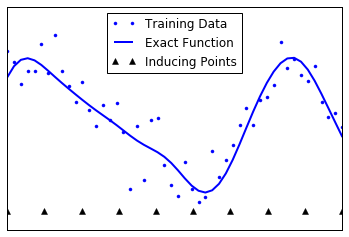

In [2]:
np.random.seed(5)
n = 50
x = np.linspace(0,1,num=n).reshape((-1,1))
k = gp_grief.kern.GPyKernel(1, kernel='RBF', lengthscale=0.1)
y_test = np.random.multivariate_normal(np.zeros(n), k.cov(x)).reshape((-1,1))
noise_var = 0.5**2
y = y_test + np.sqrt(noise_var)*np.random.randn(*y_test.shape)
grid = gp_grief.grid.InducingGrid(x=x, mbar=10)
fig,ax = plt.subplots()
plt.plot(x,y,'b.', label="Training Data")
plt.plot(x,y_test,'b-', lw=2, label="Exact Function")
plt.plot(grid.xg[0], np.zeros(grid.xg[0].shape)-2.5, 'k^', label="Inducing Points")
plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False,labelleft=False)
plt.legend(loc=0);

Get the GRId-structured Eigen-Functions (GRIEF) and plot the approximated kernel. 
This example uses $p=10$ basis functions.
The comments also demonstrate how other basis functions could be used.

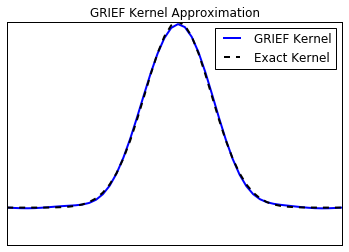

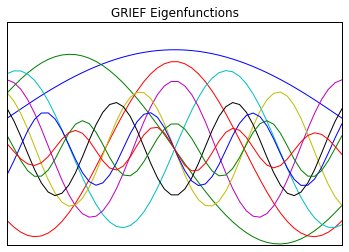

In [3]:
# generate the grid-structured eigenfunctions
kern = gp_grief.kern.GriefKernel(kern_list=[k,], grid=grid, n_eigs=10, w=1.)
m_grief = gp_grief.models.GPGrief(X=x, Y=y, kern=kern, noise_var=noise_var);
Phi = m_grief.kern.cov(m_grief.X)[0]

# other basis functions (e.g. random-fourier features) could be used as follows (uncomment)
# k_rff = gp_grief.kern.RBF_RFF(1, n_rffs=5, log_lengthscale=np.log(k.kern.lengthscale.values))
# Phi = k_rff.Phi(x)

figs, axs = zip(*[plt.subplots() for i in range(2)])
# plot the approximate kernel
axs[0].plot(x, (Phi.dot(Phi.T))[n//2], 'b', label='GRIEF Kernel', lw=2)
axs[0].plot(x, k.cov(x)[n//2], 'k--', label='Exact Kernel', lw=2)
axs[0].legend(loc=0)
axs[0].tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                   labelbottom=False,labelleft=False)
axs[0].set_title("GRIEF Kernel Approximation")

# plot the eigenfunctions
for i in range(Phi.shape[1]):
    axs[1].plot(x, Phi[:,(i,)], label='EF %d'%i)
axs[1].tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                   labelbottom=False,labelleft=False)
axs[1].set_title("GRIEF Eigenfunctions");

Now fix these basis functions, specify priors, and run MCMC. 
This tutorial uses an approach with an $\mathcal{O}(p^3)$ runtime complexity, however, the comments below demonstrate how to apply a linear transformation to the basis functions to achieve an $\mathcal{O}(p)$ runtime complexity by simply changing one line.
In either case, the complexity of MCMC iterations is *independent* of the number of training points.

In [4]:
# Approach with O(p^3) complexity
m = gp_grief.models.GPweb(Phi=Phi, y=y, noise_var=noise_var)

# Approach with O(p) complexity (uncomment)
# m = gp_grief.models.GPweb_transformed(Phi=Phi, y=y, noise_var=noise_var)

# initialize priors: first is the noise var then the other weights
priors = [gp_grief.stats.lognorm(lognorm_mode=noise_var, lognorm_std=0.2),] + \
         [gp_grief.stats.lognorm(lognorm_mode=1., lognorm_std=10.),]*Phi.shape[1]
m = gp_grief.models.PyMCMC_Wrapper(model=m, priors=priors)
# Pick a proposal for MCMC (here we pick a Metropolized Langevin Proposal
proposal = pm.MALAProposal(dt=0.4)
# Construct a Metropolis Hastings object
mcmc = pm.MetropolisHastings(m, proposal=proposal, db_filename=None)
# Now we can sample it:
iters = 10000
n_thin = int(max(50,   iters//1000)) # save at most 1000 samples
n_burn = int(max(1000, iters//10)) # burn no less than 10% of the total samples
print("running MCMC. n_sample=%d, n_thin=%d, n_burn=%d"%(iters,n_thin,n_burn))
chain = mcmc.sample(int(iters), num_thin=n_thin, num_burn=n_burn, verbose=True)
print "final sampled weight stats: min=%.4g, max=%.4g, ptp=%.4g, mean=%.4g, std=%.4g" % \
    tuple([fcn(chain[:,1:]) for fcn in [np.min, np.max, np.ptp, np.mean, np.std]])

running MCMC. n_sample=10000, n_thin=50, n_burn=1000

Tuning parameter `dt`: 0.400000 -> 0.480000

final sampled weight stats: min=0.01769, max=25.39, ptp=25.37, mean=3.016, std=3.557


 We can now plot the kernel realizations for all MCMC samples, and we can plot the posterior prediction. Note that for each MCMC sample we get a Gaussian predictive distribution, so for each sample we will plot the mean and variance for each sample.

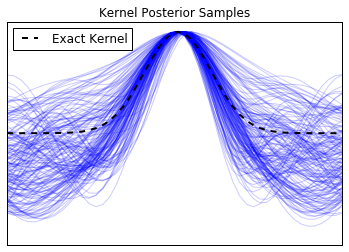

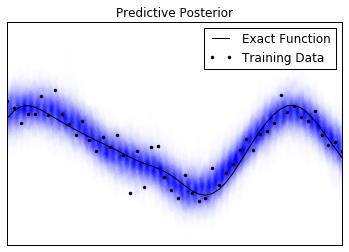

In [5]:
# loop through all posterior weight samples
fig = plt.figure()
for w in chain[:,1:]:
    k_approx = (Phi.dot(np.diag(w).dot(Phi.T)))[n//2]
    k_approx /= 1.1*k_approx.max() # scale all the kernels for visualization
    plt.plot(x, k_approx, 'b', alpha=0.2, lw=1)
plt.plot(x, k.cov(x)[n//2]/1.1, 'k--', label='Exact Kernel', lw=2)
plt.legend(loc=0)
plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False, labelleft=False)
plt.title("Kernel Posterior Samples")

# plot samples of the predictive posterior
np.random.seed(0)
fig = plt.figure()
y_sample_means, y_sample_covs = m.predict(Xnew=Phi, return_samples=True)
for i in range(y_sample_means.shape[1]): # loop through each MCMC sample
    y_gp_samp = np.random.multivariate_normal(mean=y_sample_means[:,i], 
                                              cov=y_sample_covs[:,:,i], size=3).T
    plt.plot(x, y_gp_samp, 'b', alpha=0.002, lw=5) # plot the samples
plt.plot(x, y_test, 'k', label="Exact Function")
plt.plot(x, y, 'k.', label="Training Data")
plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False, labelleft=False)
plt.legend(loc="upper right")
plt.title("Predictive Posterior");

Note that although the basis functions are fixed, the kernel still has a great amount of flexibility where it evidently explored kernels with short and long lengthscales and perhaps even some perodicity.

The predictive posterior looks quite reasonable. For this type-I model, the predictive posterior is non-Gaussian.